In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

2023-03-01 10:01:46.313060: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 10:01:46.463947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 10:01:46.463975: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-01 10:01:47.186900: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

## Data Preprocessing

In [36]:
# read dataset

dt = pd.read_csv('data_train.csv')
dt = dt.sample(frac=1)

dt

,tweet,label
1455,erwin aksa ungkap pamannya jusuf kalla tak per...,dukungan
1567,musniumar bohong mus malah di surve amblek das...,hujatan
1118,ketika anies baswedan buka suara usai diusung ...,dukungan
1146,NaN,NaN
1188,anies baswedan hanya bisa bicara omong kosong ...,hujatan
...,...,...
534,resmi nasdem deklarasi bpk anies baswedan seb...,dukungan
167,bgst,hujatan
943,NaN,NaN
187,dikit kriminalisasi yang anies lah yg ulama l...,tidak mendukung


In [37]:
# delete NaN data
dt.dropna(inplace=True)

dt

,tweet,label
1455,erwin aksa ungkap pamannya jusuf kalla tak per...,dukungan
1567,musniumar bohong mus malah di surve amblek das...,hujatan
1118,ketika anies baswedan buka suara usai diusung ...,dukungan
1188,anies baswedan hanya bisa bicara omong kosong ...,hujatan
1475,valosenadya miduk ganjarpranowo bagi buzzerban...,netral
...,...,...
198,waduh postingan buat tanggal 16 oktober 2022 u...,hujatan
308,60 kursi sahli aman sudah kaka hwakakakakakak,hujatan
534,resmi nasdem deklarasi bpk anies baswedan seb...,dukungan
167,bgst,hujatan


In [38]:
# update label

dt['label'] = dt['label'].replace({'pujian':'dukungan', 'hujatan':'tidak mendukung'})

## Data Preparation

dukungan           569
tidak mendukung    486
netral             181
Name: label, dtype: int64

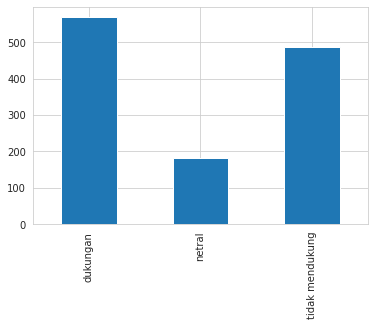

In [40]:
# visualize data

dt['label'].value_counts().sort_index().plot.bar()
plt.savefig('hasildataset.jpeg', dpi=300, bbox_inches='tight')
dt['label'].value_counts()

# Oversampling

In [6]:
minority_class = 'netral'
num_samples_to_oversample = dt['label'].value_counts()['dukungan'] - dt['label'].value_counts()[minority_class]

In [7]:
minority_df = dt[dt['label'] == minority_class]

In [8]:
oversampled_df = minority_df.sample(num_samples_to_oversample, replace=True)


In [9]:
dt = pd.concat([dt, oversampled_df])

In [10]:
minority_class = 'tidak mendukung'
num_samples_to_oversample = dt['label'].value_counts()['dukungan'] - dt['label'].value_counts()[minority_class]

In [11]:
minority_df = dt[dt['label'] == minority_class]

In [12]:
oversampled_df = minority_df.sample(num_samples_to_oversample, replace=True)

In [13]:
dt = pd.concat([dt, oversampled_df])

dukungan           569
netral             569
tidak mendukung    569
Name: label, dtype: int64

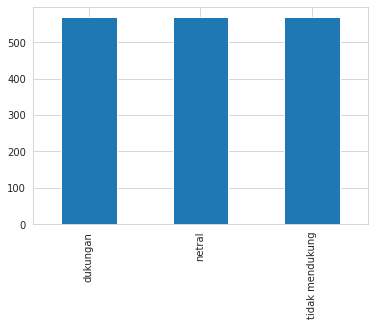

In [35]:
dt['label'].value_counts().sort_index().plot.bar()
plt.savefig('hasiloversampling.jpeg', dpi=300, bbox_inches='tight')
dt['label'].value_counts()

In [15]:
# tokenizer text

tokenizer = Tokenizer(num_words=5000, split=" ")

tokenizer.fit_on_texts(dt['tweet'].values)
X = tokenizer.texts_to_sequences(dt['tweet'].values)
X = pad_sequences(X)
print(X)

[[   0    0    0 ... 2396   40   95]
 [   0    0    0 ...  184 1297 2399]
 [   0    0    0 ...  133  999    3]
 ...
 [   0    0    0 ... 1530 1531  131]
 [   0    0    0 ... 1200  442  352]
 [   0    0    0 ...   43   71  957]]


In [16]:
# get label

y = pd.get_dummies(dt['label']).values
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [17]:
print(y.shape)

(1707, 3)


In [18]:
# split dataset smote tanpa menggunakan tokenizing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(1365, 51)
(342, 51)


## Training Model

In [19]:
# LSTM Modelling

model = Sequential()
model.add(Embedding(5000, 256))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2023-03-01 10:01:56.515543: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-01 10:01:56.515637: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-01 10:01:56.515710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-01 10:01:56.515783: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-03-01 10:01:56.515860: W tensorfl

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         1280000   
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 lstm (LSTM)                 (None, None, 256)         525312    
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 2,331,395
Trainable params: 2,331,395
Non-trainable params: 0
_________________________________________________________________


In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
batch_size = 32
epochs = 25

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, validation_data=(X_test, y_test))

Epoch 1/25
43/43 - 22s - loss: 1.0496 - accuracy: 0.4337 - val_loss: 0.9388 - val_accuracy: 0.5994 - 22s/epoch - 504ms/step
Epoch 2/25
43/43 - 17s - loss: 0.7097 - accuracy: 0.7070 - val_loss: 0.6101 - val_accuracy: 0.7544 - 17s/epoch - 384ms/step
Epoch 3/25
43/43 - 17s - loss: 0.2823 - accuracy: 0.8938 - val_loss: 0.5406 - val_accuracy: 0.7953 - 17s/epoch - 397ms/step
Epoch 4/25
43/43 - 20s - loss: 0.1157 - accuracy: 0.9604 - val_loss: 0.5907 - val_accuracy: 0.8187 - 20s/epoch - 459ms/step
Epoch 5/25
43/43 - 20s - loss: 0.0496 - accuracy: 0.9810 - val_loss: 0.6011 - val_accuracy: 0.7924 - 20s/epoch - 470ms/step
Epoch 6/25
43/43 - 18s - loss: 0.0542 - accuracy: 0.9853 - val_loss: 0.6909 - val_accuracy: 0.8333 - 18s/epoch - 430ms/step
Epoch 7/25
43/43 - 18s - loss: 0.0299 - accuracy: 0.9897 - val_loss: 0.8050 - val_accuracy: 0.8363 - 18s/epoch - 425ms/step
Epoch 8/25
43/43 - 26s - loss: 0.0360 - accuracy: 0.9897 - val_loss: 0.7460 - val_accuracy: 0.8246 - 26s/epoch - 594ms/step
Epoch 9/

In [ ]:
# save model into file .h5

model.save('sentiment_analysis.h5')

In [22]:
# Mengambil data dari history pelatihan model
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [23]:
# Membuat plot
plt.figure(figsize=(12,5))
sns.set_style("whitegrid")

<Figure size 864x360 with 0 Axes>

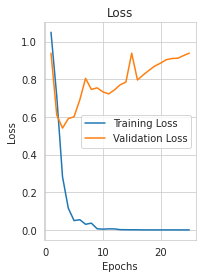

In [32]:
plt.subplot(1,2,1)
sns.lineplot(x=range(1,epochs+1), y=train_loss, label='Training Loss')
sns.lineplot(x=range(1,epochs+1), y=val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('hasilplot1.jpeg', dpi=300, bbox_inches='tight')

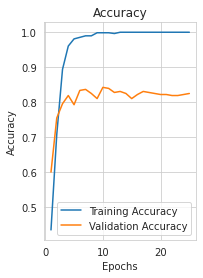

In [33]:
plt.subplot(1,2,2)
sns.lineplot(x=range(1,epochs+1), y=train_acc, label='Training Accuracy')
sns.lineplot(x=range(1,epochs+1), y=val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('hasilplot2.jpeg', dpi=300, bbox_inches='tight')
plt.show()

In [26]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

11/11 [==============================] - 1s 71ms/step
              precision    recall  f1-score   support

           0       0.87      0.73      0.79       129
           1       0.80      0.99      0.89       108
           2       0.80      0.77      0.79       105

    accuracy                           0.82       342
   macro avg       0.83      0.83      0.82       342
weighted avg       0.83      0.82      0.82       342



In [27]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

[[ 94  16  19]
 [  0 107   1]
 [ 14  10  81]]


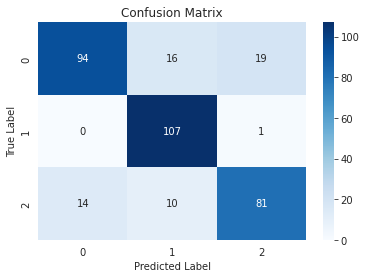

In [28]:
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

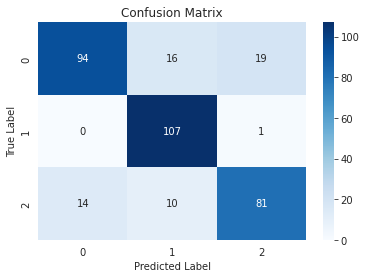

In [41]:
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('hasil.jpeg', dpi=300, bbox_inches='tight')

## Evaluate Model

In [29]:
# evaluate model with data test

score, acc = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

11/11 - 1s - loss: 0.9387 - accuracy: 0.8246 - 737ms/epoch - 67ms/step
score: 0.94
acc: 0.82


## Predict New Dataset

In [58]:
# read new dataset
import re
import numpy as np
import pandas as pd
data = pd.read_csv('tweet2.csv')
# menghapus kolom id
data = data.drop(['id'], axis=1)

data

,tweet
0,"@M45Broo_ Cebong benar2 panik luar biasa, ini ..."
1,@Relawananies https://t.co/uf5sE0iGLI
2,RT @BosPurwa: #IndonesiaMemanggil \n5 Tahun An...
3,RT @aLy_Bima: Video ini hanya untuk orang yang...
4,"RT @tempodotco: ""Tidak ringan permasalahan di ..."
...,...
445,RT @Relawananies: Momen haru saat Anies Baswed...
446,@maspiyuaja Terima kasih om https://t.co/PUgr2...
447,RT @BosPurwa: #IndonesiaMemanggil \n5 Tahun An...
448,RT @OposisiCerdas: Kamhar Lakumani Sebut Anies...


In [59]:
# data preprocessing

def tweetPrepocessing(text):
  text = text.lower()
  text = re.sub('\n','', text)
  text = re.sub('rt ','', text)
  text = re.sub('#','', text)
  text = re.sub('@\w+(?:\:)\ ','', text)
  text = re.sub(r'(?:\@|http?\://|https?\://|www)\S+','', text)
  text = re.sub('[^a-zA-z0-9\s]','', text)
  text = re.sub('  ',' ', text)

  if text == ' ':
    return None

  return text

data = data.sample(frac=1)
data['tweet'] = data['tweet'].apply(tweetPrepocessing)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace = True)

data

,tweet
0,wahhhaneksasi itu
1,indonesiamemanggil 5 tahun anies baswedan memi...
2,awas kena diare lagi om
3,anies baswedan duduk bareng elite parpol pks k...
4,kwekkwek
...,...
430,kwekkwek
431,bapak christoforus rea tokoh ummat katolik nam...
432,sejak kemarin anies baswedan bukan lagi gubern...
433,video ini hanya untuk orang yang belum tahu pr...


In [60]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=5000, split=" ")

tokenizer.fit_on_texts(data['tweet'].values)
X = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X)
print(X)


tokenizer.fit_on_texts(data['tweet'].values)

X_new = tokenizer.texts_to_sequences(data['tweet'].values)
X_new = pad_sequences(X_new)
X_new.shape

[[   0    0    0 ...    0  631   47]
 [   0    0    0 ...   41   42   43]
 [   0    0    0 ...  632   79  427]
 ...
 [   0    0    0 ...   51    7  265]
 [   0    0    0 ...   45    1    2]
 [   0    0    0 ...  150  220 1549]]


(435, 42)

In [61]:
# load model
from keras.models import Sequential, load_model
mymodel = load_model('sentiment_analysis.h5')

In [64]:
# predict data

pred = mymodel.predict(X_new)


14/14 [==============================] - 1s 50ms/step


In [53]:
# labelling

def labelling(array):
  labels = ['dukungan', 'netral', 'tidak mendukung']
  output = []
  for a in array:
    output.append(labels[np.argmax(a)])
  return output

label = labelling(pred)

In [54]:
# add label to data

data['label'] = label

data

,tweet,label
0,kenduri rakyat jarnas anies baswedan yogyakart...,netral
1,brengsek anies baswedan gak bisa kerja sekaran...,netral
2,hanya pandai omdo ajakelebihan bayar dn php,netral
3,ketum partai gerindra prabowo subianto memilik...,tidak mendukung
4,indonesiamemanggil 5 tahun anies baswedan memi...,tidak mendukung
...,...,...
430,sinyal buat koalisi ak2412 oktoober 2022jender...,netral
431,janji anies baswedan menjadi jancukkepulauan b...,dukungan
432,kenapa disaat last lap pencitraan,tidak mendukung
433,partai koalisi pemerintah 82 suaranya di parle...,dukungan


In [43]:
# save to new csv

data.to_csv('tweet2_new.csv', index=False)